## Without using SVD()

In [1]:
if (!require("pixmap")) {
    install.packages("pixmap")
}

if (!require("bmp")) {
    install.packages("bmp")
}

if (!require("magick")) {
    install.packages("magick")
}

library("pixmap")
library("bmp")
library("magick")

Loading required package: pixmap

Loading required package: bmp

Loading required package: magick

Linking to ImageMagick 6.9.12.3
Enabled features: cairo, freetype, fftw, ghostscript, heic, lcms, pango, raw, rsvg, webp
Disabled features: fontconfig, x11



In [3]:
my_image = read.bmp("ImagesForSVDCompression/IMG_7073-modified.bmp")
# my_image
dim(my_image)

[1] 1726 1535    3

In [5]:
my_image.size = file.info("ImagesForSVDCompression/IMG_7073-modified.bmp")$size
my_image.size_kb = my_image.size / 1024
my_image.size_kb

[1] 7767.135

Warning message in rep(cellres, length = 2):
"'x' is NULL so the result will be NULL"


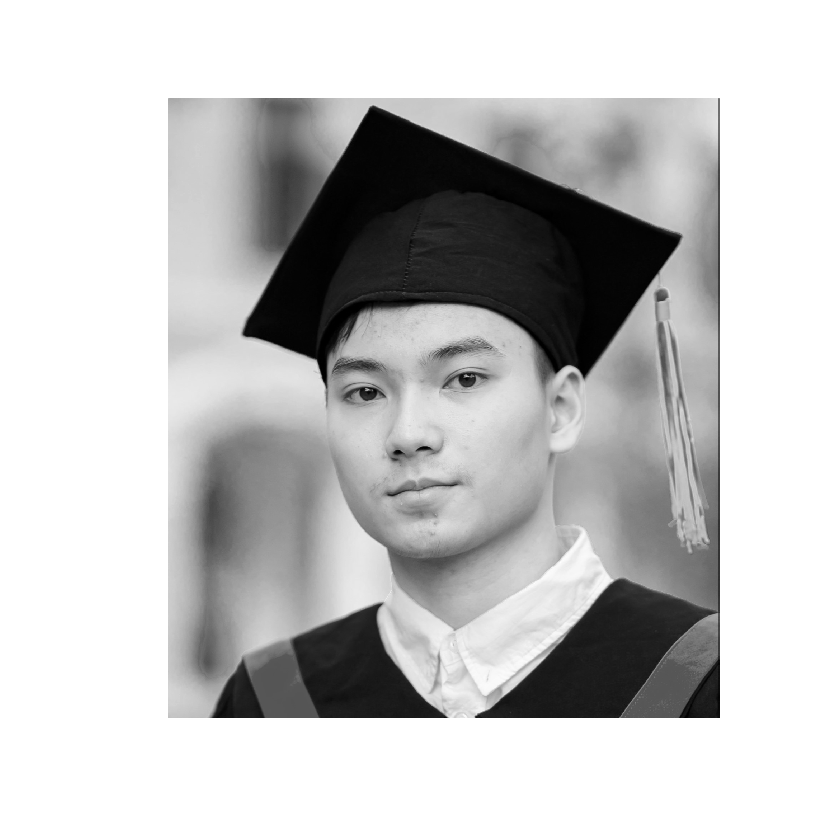

In [7]:
my_image_grey = pixmapGrey(my_image)
plot(my_image_grey)

In [9]:
my_image_grey

Pixmap image
  Type          : pixmapGrey 
  Size          : 1726x1535 
  Resolution    : 1x1 
  Bounding box  : 0 0 1535 1726 


In [11]:
my_image_grey.size = file.info("ImagesForSVDCompression/IMG_7073-modified.bmp")$size
my_image.size_kb = my_image.size / 1024
my_image.size_kb

[1] 7767.135

In [13]:
M = my_image_grey@grey
M[1:5, 1:5]

0.6720648,0.6680162,0.6680162,0.6639676,0.6639676
0.6720648,0.6720648,0.6680162,0.6680162,0.6639676
0.6761134,0.6761134,0.6720648,0.6720648,0.6680162
0.6761134,0.6761134,0.6761134,0.6720648,0.6720648
0.6761134,0.6761134,0.6761134,0.6761134,0.6761134


In [15]:
MtM = t(M) %*% M

In [17]:
eigensMtM = eigen(MtM)
eigensMtM_values = eigensMtM$values
length(eigensMtM_values)

[1] 1535

In [19]:
sigma_vec = c()
for (i in eigensMtM_values) {
    if (i > 0) {
        sigma_vec = c(sigma_vec, sqrt(i))
    }
}

length(sigma_vec)

[1] 1535

In [21]:
sigmaMatrix = matrix(0, nrow = nrow(M), ncol = ncol(M))
sigmaMatrixPseudoInverse = matrix(0, nrow = nrow(M), ncol = ncol(M))
for (i in 1:length(sigma_vec)) {
  sigmaMatrix[i, i] = sigma_vec[i]
  sigmaMatrixPseudoInverse[i, i] = 1/sigma_vec[i]
}
sigmaMatrixPseudoInverse = t(sigmaMatrixPseudoInverse)
nrow(sigmaMatrix)

[1] 1726

In [23]:
V = eigensMtM$vectors
nrow(V)

[1] 1535

In [25]:
U = matrix(0, nrow = nrow(M), ncol = nrow(M))

for (i in 1:length(sigma_vec)) {
    u = (1/sigma_vec[i]) * M %*% V[, i]
    u = u/sqrt(sum(u^2))
    U[, i] = u
}

$M_{n \times m}^{k-compressed} = U_{n \times k} \times \Sigma_{k \times k} \times V^T_{m \times k}$

In [27]:
# S = diag(sqrt(eigenMtM$value[eigenMtM$value]), nrow=nrow(M), ncol=ncol(M))
S = sigmaMatrix
compressedIMG = function(k) {
    M_k = U[, 1:k] %*% S[1:k, 1:k] %*% t(V[, 1:k])
    compressed_img = pixmapGrey(M_k)
    return (compressed_img)
}

Warning message in rep(cellres, length = 2):
"'x' is NULL so the result will be NULL"


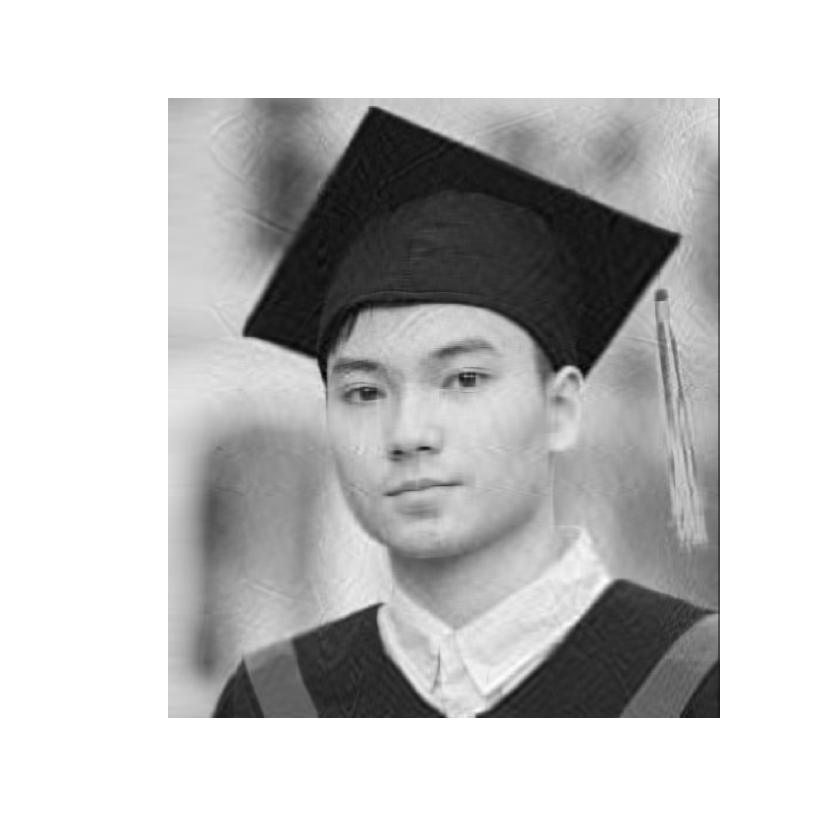

In [29]:
plot(compressedIMG(50))

Warning message in rep(cellres, length = 2):
"'x' is NULL so the result will be NULL"


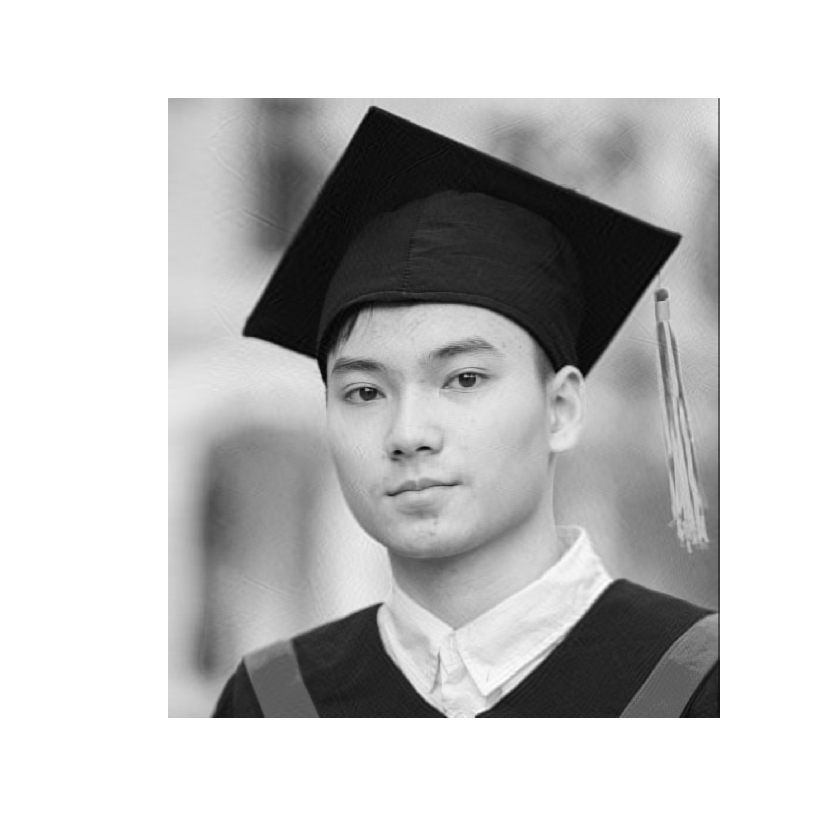

In [31]:
plot(compressedIMG(100))

### 100 singular values looks good enough. 

In [35]:
# theoratical_size_ratio  
k = 100
(k^2 + k*(dim(my_image)[1] + dim(my_image)[2])) / (dim(my_image)[1] * dim(my_image)[2])

[1] 0.1268584

### The theoratical size ratio for 100 singular values compressed image with the original image is 0.13.

## Using SVD()

In [41]:
mySVD = svd(M, nu=nrow(M), nv=ncol(M))
myU = mySVD$u
myV = mySVD$v
myS = diag(mySVD$d, nrow=nrow(M), ncol=ncol(M))

myCompressedIMG = function(k) {
    M_k = myU[, 1:k] %*% myS[1:k, 1:k] %*% t(myV[, 1:k])
    return (pixmapGrey(M_k))
}

Warning message in rep(cellres, length = 2):
"'x' is NULL so the result will be NULL"


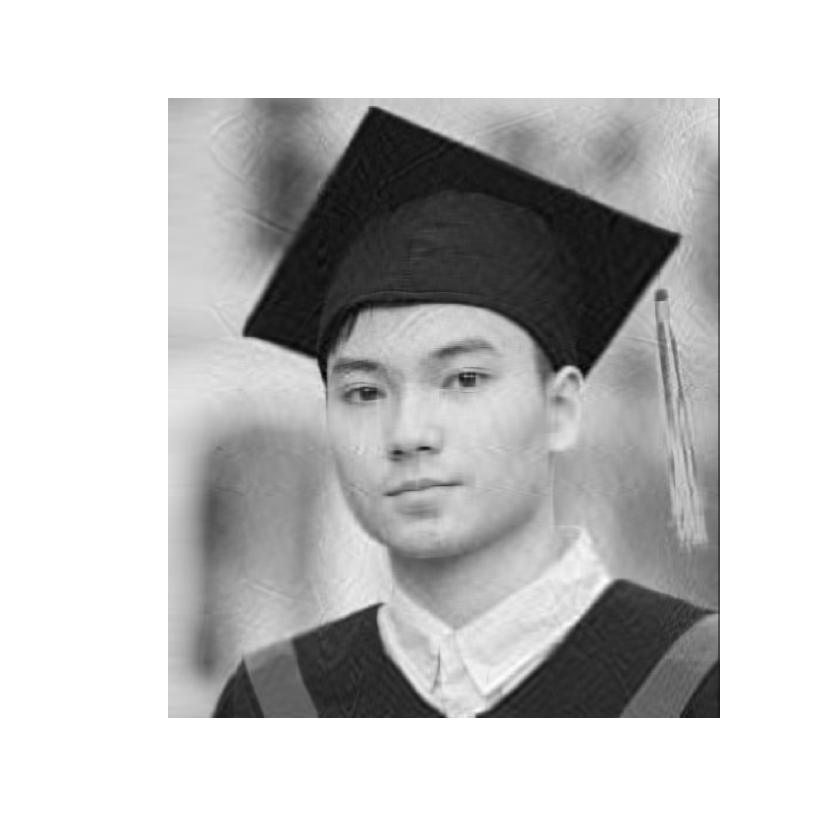

In [47]:
compressed_img.50 = myCompressedIMG(50)
plot(compressed_img.50)

In [83]:
image_matrix = compressed_img.50@grey

# Convert the matrix to an image object (values are already 0–1)
img = image_read(as.raster(image_matrix))

# Save as PNG
image_write(img, path = "ImagesForSVDCompression/compressed_image_50.png", format = "png")

## This function takes in a `png` image, the output `png` file name and the number of singular values needed, then compresses the image and save it for you as well as returning the image size before and after compressed.

Warning message in rep(cellres, length = 2):
"'x' is NULL so the result will be NULL"
Warning message in rep(cellres, length = 2):
"'x' is NULL so the result will be NULL"


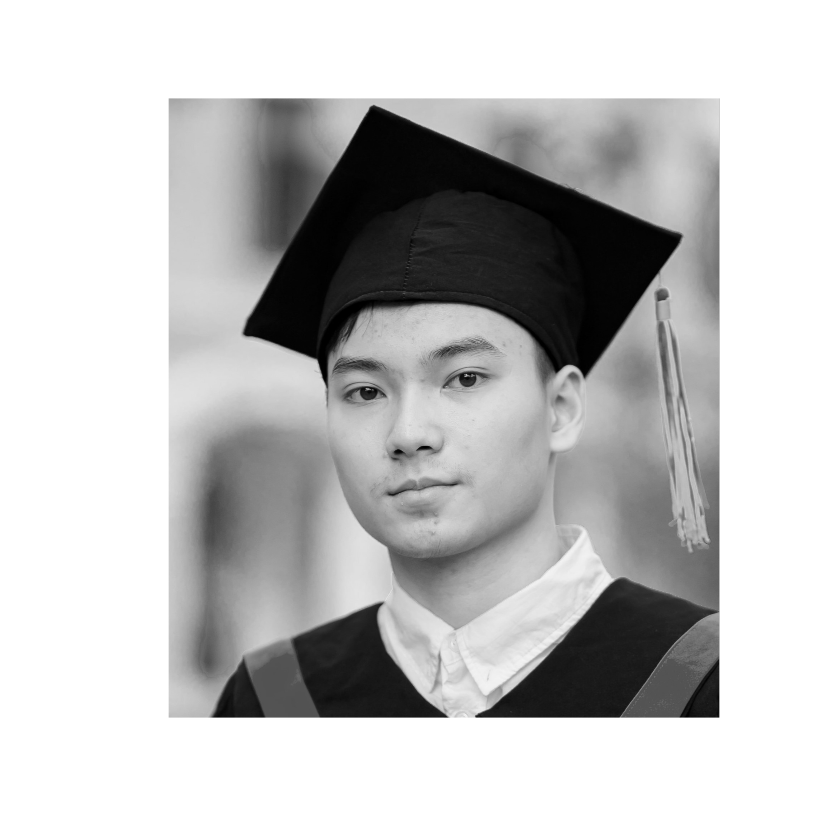

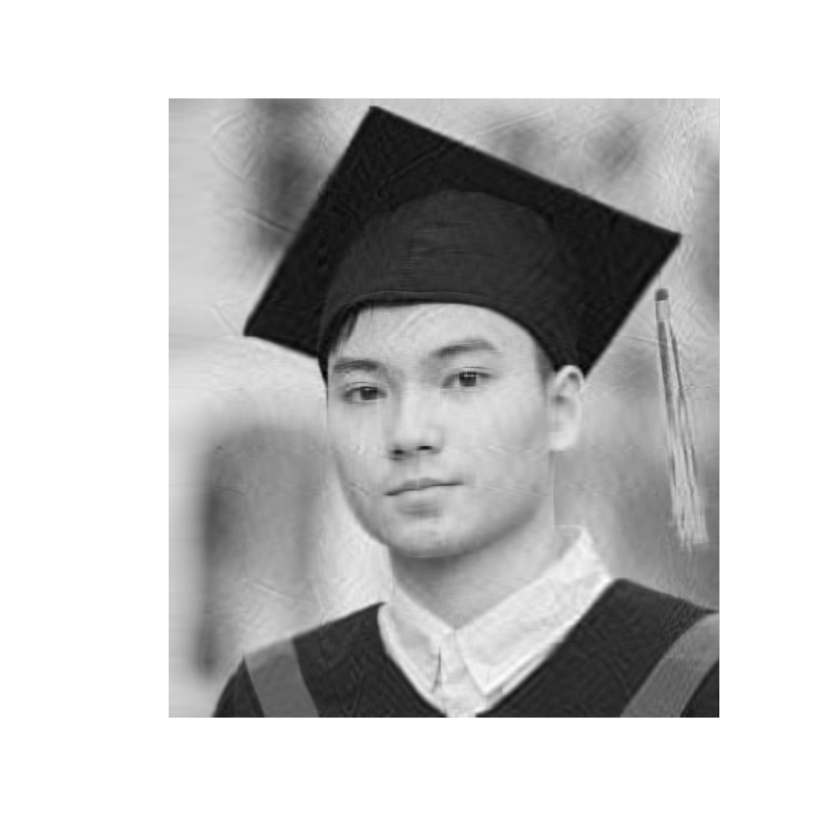

In [183]:
compress = function(image_name, compressed_image_name, k = 50) {

    original_file_size_kb = file.info(image_name)$size / 1024
    
    # Read the PNG file using magick
    img = image_read(image_name)
    plot(img)
    
    image_write(img, path = "ImagesForSVDCompression/temp.bmp", format = "bmp", compression = "none")

    # writeImage(img, bmp_file, quality = 100)  # Save as uncompressed BMP
    
    # Step 3: Load the BMP file as a pixmapGrey object
    my_image = read.bmp("ImagesForSVDCompression/temp.bmp")
    
    # remove the temporary file
    file.remove("ImagesForSVDCompression/temp.bmp")

    my_image_grey = pixmapGrey(my_image)
    
    M = my_image_grey@grey

    mySVD = svd(M, nu=nrow(M), nv=ncol(M))
    U = mySVD$u
    V = mySVD$v
    S = diag(mySVD$d, nrow=nrow(M), ncol=ncol(M))

    M_k = U[, 1:k] %*% S[1:k, 1:k] %*% t(V[, 1:k])
    compressed_image = pixmapGrey(M_k)

    compressed_image_matrix = compressed_img@grey
    compressed_img = image_read(as.raster(compressed_image_matrix))
    image_write(compressed_img, path = compressed_image_name, format = "png")

    compressed_file_size_kb = file.info(compressed_image_name)$size / 1024

    plot(compressed_img)

    theoratical_size_ratio = (k^2 + k*(dim(my_image)[1] + dim(my_image)[2])) / (dim(my_image)[1] * dim(my_image)[2])
    # can be smaller if store k singular values instead of S[1:k, 1:k]
    
    return (list(image_size_kb = original_file_size_kb, compressed_size_kb = compressed_file_size_kb, theoratical_size_ratio = theoratical_size_ratio))
}

result = compress("ImagesForSVDCompression/IMG_7073-modified.png", "ImagesForSVDCompression/compressed50.png", 50)

In [181]:
result

$image_size_kb
[1] 1098.629

$compressed_size_kb
[1] 578.2686

$theoratical_size_ratio
[1] 0.06248561

**By using 50 singular values, the size of the image is reduced by half**